In [1]:
import sys
sys.path.append('../..') 
import numpy as np
import cv2 as cv
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from keras import layers
from tensorflow import keras
import gc
import matplotlib.pyplot as plt
from tools.GA.FilterGeneticAlgorithm import FilterGeneticAlgorithm
import random as rnd

In [2]:
path = "../datasets/Images/Skin canser"

items = os.listdir(path)

folder_paths = [path+"/"+item for item in items if os.path.isdir(os.path.join(path, item))]

for path in folder_paths:
    print(path)

../datasets/Images/Skin canser/benign
../datasets/Images/Skin canser/malignant


In [3]:
def get_Data(folder_path,cls):
    X = []
    Y=[]
    for root, directories, files in os.walk(folder_path):
        for filename in files:
            img=cv.imread(os.path.join(root, filename))
            img=cv.cvtColor(img, cv.COLOR_RGB2BGR)
            X.append(img)
            Y.append(cls)
    return X,Y

In [4]:
X=[]
Y=[]

for cls,folder_path in enumerate(folder_paths):
    x,y=get_Data(folder_path,cls)
    X=X+x
    Y=Y+y

In [5]:
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.3)

In [6]:
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_test=np.array(X_test)
Y_test=np.array(Y_test)

print(f"X_train:{X_train.shape} Y_train:{Y_train.shape} X_test:{X_test.shape} Y_test:{Y_test.shape}")

X_train:(2307, 224, 224, 3) Y_train:(2307,) X_test:(990, 224, 224, 3) Y_test:(990,)


In [7]:
model = keras.models.Sequential([
    layers.BatchNormalization(input_shape=(224, 224, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Flatten(),
    layers.Dense(2, activation='softmax')
])

In [8]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
splits = list(kf.split(X_test))

In [9]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
evaluations=0

for train_index, test_index in splits.copy():
    m= keras.models.clone_model(model)

    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(X_test)[train_index], np.array(X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=1, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]

    gc.collect()
print(evaluations/10)

4/4 [==============================] - 0s 13ms/step - loss: 0.9541 - accuracy: 0.6768
0.5747474789619446


In [10]:
from weka.classifiers import Classifier, Evaluation
import weka.core.converters as converters
from weka.core.classes import Random
from weka.filters import Filter
import weka.core.jvm as jvm
from weka.core.dataset import create_instances_from_matrices
import csv

jvm.start(system_cp=True, packages=True, max_heap_size="12g")

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Adding system classpath
DEBUG:weka.core.jvm:Classpath=['C:\\Users\\ch\\miniconda3\\envs\\tf\\Lib\\site-packages\\javabridge\\jars\\rhino-1.7R4.jar', 'C:\\Users\\ch\\miniconda3\\envs\\tf\\Lib\\site-packages\\javabridge\\jars\\runnablequeue.jar', 'C:\\Users\\ch\\miniconda3\\envs\\tf\\Lib\\site-packages\\javabridge\\jars\\cpython.jar', 'c:\\Users\\ch\\miniconda3\\envs\\tf\\lib\\site-packages\\weka\\lib\\arpack_combined.jar', 'c:\\Users\\ch\\miniconda3\\envs\\tf\\lib\\site-packages\\weka\\lib\\core.jar', 'c:\\Users\\ch\\miniconda3\\envs\\tf\\lib\\site-packages\\weka\\lib\\mtj.jar', 'c:\\Users\\ch\\miniconda3\\envs\\tf\\lib\\site-packages\\weka\\lib\\python-weka-wrapper.jar', 'c:\\Users\\ch\\miniconda3\\envs\\tf\\lib\\site-packages\\weka\\lib\\weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=12g
DEBUG:weka.core.jvm:Package support enabled


In [11]:
def flatten_extend(matrix):
    return [item for row in matrix for item in row]

def images_to_vectors(images):
    vectors=[]
    for img in images:
        vectors.append(np.array(img).flatten())     
    return vectors

X_train_vectors= images_to_vectors(X_train)
X_test_vectors= images_to_vectors(X_test)
print(f"train: {np.array(X_train_vectors).shape}")
print(f"test: {np.array(X_test_vectors).shape}")

train: (2307, 150528)
test: (990, 150528)


In [ ]:
ga=FilterGeneticAlgorithm(X_train=X_train,X_test=X_test,Y_train=Y_train,Y_test=Y_test, model=model, loss=keras.losses.SparseCategoricalCrossentropy())

In [ ]:
best_solution= ga.run(generation_limit=5, population_size=14)

--------------------------------------------------------------------------------
8/8 [==============================] - 0s 14ms/step - loss: 1.6099 - accuracy: 0.6609
filter [0, 179, 0, 255, 0, 255, 0, 0, 0, 0, 5, 1, 1, 100, 200, 0] fit: 0.6111801236867904
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 13ms/step - loss: 0.6892 - accuracy: 0.5478
filter [12, 100, 48, 107, 31, 172, 85, 184, 85, 189, 28, 5, 1, 20, 480, 0] fit: 0.544869190454483
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 13ms/step - loss: 0.7378 - accuracy: 0.7130
filter [56, 161, 39, 130, 14, 218, 99, 48, 111, 17, 2, 1, 1, 114, 46, 0] fit: 0.7151835143566132
--------------------------------------------------------------------------------
8/8 [==============================] - 0s 13ms/step - loss: 0.6822 - accuracy: 0.5652
filter [38, 114, 47, 136, 43, 225, 69, 162, 61,

In [ ]:
print(f"\nbest filter :{best_solution.filter} fit: {best_solution.fit}")


best filter :[37, 115, 48, 222, 52, 232, 50, 51, 159, 94, 5, 3, 2, 2, 62, 0] fit: 0.7763523459434509


In [ ]:
new_X_test=np.array(ga.get_newData(X_test,best_solution.filter))

new_X_test.shape

(990, 224, 224, 3)

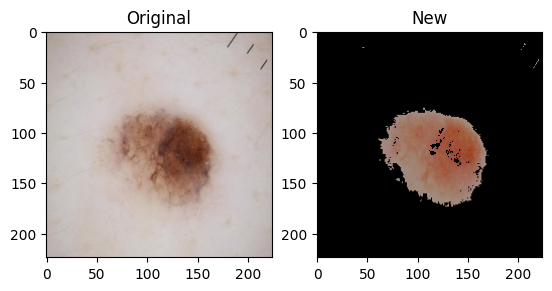

In [ ]:
index=rnd.randint(0,len(X_test))

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(X_test[index])
ax1.set_title('Original')

ax2.imshow(new_X_test[index])
ax2.set_title('New')

plt.show()

In [ ]:
evaluations=0

for train_index, test_index in splits.copy():
    m= keras.models.clone_model(model)

    m.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

    train_index, test_index = train_index.tolist(), test_index.tolist()
    x_train, x_test, y_train, y_test = np.array(new_X_test)[train_index], np.array(new_X_test)[test_index], np.array(Y_test)[train_index], np.array(Y_test)[test_index]

    m.fit(x_train, y_train, epochs=1, batch_size=32)
    evaluations+=m.evaluate(x_test,y_test)[1]

    gc.collect()
print(evaluations/10)

4/4 [==============================] - 0s 15ms/step - loss: 1.0488 - accuracy: 0.6364
0.7202020168304444
